<a 
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab6.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Lab 6: Sequence-to-sequence models

### Description:
For this lab, you will code up the [char-rnn model of Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). This is a recurrent neural network that is trained probabilistically on sequences of characters, and that can then be used to sample new sequences that are like the original.

This lab will help you develop several new skills, as well as understand some best practices needed for building large models. In addition, we'll be able to create networks that generate neat text!

### Deliverable:
- Fill in the code for the RNN (using PyTorch's built-in GRU).
- Fill in the training loop
- Fill in the evaluation loop. In this loop, rather than using a validation set, you will sample text from the RNN.
- Implement your own GRU cell.
- Train your RNN on a new domain of text (Star Wars, political speeches, etc. - have fun!)

### Grading Standards:
- 20% Implementation the RNN
- 20% Implementation training loop
- 20% Implementation of evaluation loop
- 20% Implementation of your own GRU cell
- 20% Training of your RNN on a domain of your choice

### Tips:
- Read through all the helper functions, run them, and make sure you understand what they are doing
- At each stage, ask yourself: What should the dimensions of this tensor be? Should its data type be float or int? (int is called `long` in PyTorch)
- Don't apply a softmax inside the RNN if you are using an nn.CrossEntropyLoss (this module already applies a softmax to its input).

### Example Output:
An example of my final samples are shown below (more detail in the
final section of this writeup), after 150 passes through the data.
Please generate about 15 samples for each dataset.

<code>
And ifte thin forgision forward thene over up to a fear not your
And freitions, which is great God. Behold these are the loss sub
And ache with the Lord hath bloes, which was done to the holy Gr
And appeicis arm vinimonahites strong in name, to doth piseling 
And miniquithers these words, he commanded order not; neither sa
And min for many would happine even to the earth, to said unto m
And mie first be traditions? Behold, you, because it was a sound
And from tike ended the Lamanites had administered, and I say bi
</code>


---

## Part 0: Readings, data loading, and high level training

---

There is a tutorial here that will help build out scaffolding code, and get an understanding of using sequences in pytorch.

* Read the following

> * [Pytorch sequence-to-sequence tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) (Take note that you will not be implementing the encoder part of this tutorial.)
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)






In [ ]:
! wget -O ./text_files.tar.gz 'https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz' 
! tar -xzf text_files.tar.gz
! pip install unidecode
#! pip install torch

In [2]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import pdb

In [3]:
all_characters = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZñáéíóúüÁÉÍÓÚÜÑ¡!\"#$%&'()*+,-./:;«<=>»¿?@[\]^_`{|}~ \t\n\r\x0b\x0c"
n_characters = len(all_characters)

file_name = './text_files/don-quijote-espanol.txt'

file = unidecode.unidecode(open(file_name, 'r', encoding='utf8').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 2098300


In [4]:
all_characters

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZñáéíóúüÁÉÍÓÚÜÑ¡!"#$%&\'()*+,-./:;«<=>»¿?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [5]:
chunk_len = 200
 
def random_chunk():
  start_index = random.randint(0, file_len - chunk_len)
  end_index = start_index + chunk_len + 1
  return file[start_index:end_index]


In [ ]:
# Turn string into list of longs
def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
      tensor[c] = all_characters.index(string[c])
  return tensor

print(char_tensor('abcDEFñáíó¡»'))

---

## Part 4: Creating your own GRU cell 

**(Come back to this later - its defined here so that the GRU will be defined before it is used)**

---

The cell that you used in Part 1 was a pre-defined Pytorch layer. Now, write your own GRU class using the same parameters as the built-in Pytorch class does.

Please try not to look at the GRU cell definition. The answer is right there in the code, and in theory, you could just cut-and-paste it. This bit is on your honor!

**TODO:**

**DONE:**

* Create a custom GRU cell


In [7]:
class GRUCell(nn.Module):
    # Output and hidden size are synonymous
    def __init__(self, input_size, hidden_size):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

        self.W_r = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_z = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_n = nn.Linear(input_size + hidden_size, hidden_size)

    # input comes from previous layer, prev_hidden comes from previous GRU in time
    def forward(self, input, prev_hidden):
        # Each layer does the following:
        # r_t = sigmoid(W_ir*x_t + b_ir . W_hr*h_(t-1) + b_hr)
        # z_t = sigmoid(W_iz*x_t + b_iz . W_hz*h_(t-1) + b_hz)
        # n_t = tanh(W_in*x_t + b_in . r_t**(W_hn*h_(t-1) + b_hn))
        # h_(t) = (1 - z_t)**n_t + z_t**h_(t-1)
        # Where ** is hadamard product (not matrix multiplication, but elementwise multiplication)

        update_input = torch.cat((input, prev_hidden), dim=2)
        update_gate = self.sigmoid(self.W_z(update_input))

        reset_input = update_input.clone()
        reset_gate = self.sigmoid(self.W_r(reset_input))

        curr_mem_input = torch.cat(((reset_gate * prev_hidden), input), dim=2)
        curr_memory = self.tanh(self.W_n(curr_mem_input))

        final_memory = ((1 - update_gate) * curr_memory) + (update_gate * prev_hidden)

        # Produce two verisons of this because it will be used in two places
        return final_memory, final_memory
    


class MyGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(MyGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru_cells = nn.ModuleList()

        for i in range(self.num_layers):
            # First gru cell takes input_size the rest are hidden_size
            gru_input_size = self.input_size if i == 0 else hidden_size
            self.gru_cells.append(GRUCell(gru_input_size, hidden_size))
  
    def forward(self, inputs, hidden):
        # Use first gru cell to initialize hidden_layers
        outputs, hidden_layers = self.gru_cells[0](inputs, hidden[0:1])
        for i, cell in enumerate(self.gru_cells):
            outputs, hidden_layer = cell(outputs, hidden[i:i+1])
            hidden_layers = torch.cat((hidden_layers, hidden_layer), dim=0)

        return outputs, hidden_layers
  


---

##  Part 1: Building a sequence to sequence model

---

Great! We have the data in a useable form. We can switch out which text file we are reading from, and trying to simulate.

We now want to build out an RNN model, in this section, we will use all built in Pytorch pieces when building our RNN class.


**TODO:**

**DONE:**

* Create an RNN class that extends from nn.Module.



In [8]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(MyRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = n_layers

        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        self.gru = MyGRU(self.hidden_size, self.hidden_size, num_layers=self.num_layers)
        self.to_out_size = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq, hidden):
        output = torch.Tensor([])
        #for i in range(len(input_seq)):
        output = self.embedding(input_seq).view(1, 1, -1)
        output, hidden = self.gru(output, hidden)
        output = F.relu(self.to_out_size(output))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size)

In [9]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

---

## Part 2: Sample text and Training information

---

We now want to be able to train our network, and sample text after training.

This function outlines how training a sequence style network goes. 

**TODO:**

**DONE:**
* Fill in the pieces.




In [10]:
def train(inp, target, model, loss_func, optimizer):
    ## initialize hidden layers, set up gradient and loss 
    optimizer.zero_grad()
    hidden = decoder.init_hidden()
    loss = 0

    for i in range(len(inp)):
        out_distribution, hidden = model(inp[i], hidden)
        out_distribution = out_distribution.squeeze(0)
        loss += loss_func(out_distribution, target[i].view(-1))

    loss.backward()
    optimizer.step()

    return loss.item() / len(inp)


---

## Part 3: Sample text and Training information

---

You can at this time, if you choose, also write out your train loop boilerplate that samples random sequences and trains your RNN. This will be helpful to have working before writing your own GRU class.

If you are finished training, or during training, and you want to sample from the network you may consider using the following function. If your RNN model is instantiated as `decoder`then this will probabilistically sample a sequence of length `predict_len`

**TODO:**
* Fill out the evaluate function to generate text frome a primed string

**DONE:**



In [11]:
def sample_outputs(output, temperature):
    """Takes in a vector of unnormalized probability weights and samples a character from the distribution"""
    return torch.multinomial(torch.exp(output / temperature), 1)

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    ## initialize hidden state, initialize other useful variables
    ## take output from decoder()
    with torch.no_grad():
        prime_input = char_tensor(prime_str)
        hidden = decoder.init_hidden()
        for p in range(len(prime_str) - 1):
            _, hidden = decoder(prime_input[p], hidden)

        inp = prime_input[-1]
        for i in range(predict_len):
            decoded_out, hidden = decoder(inp, hidden)
            char_picked = all_characters[sample_outputs(decoded_out.view(-1), temperature)]
            inp = char_tensor(char_picked)
            prime_str += char_picked

    return prime_str
  

---

## Part 4: (Create a GRU cell, requirements above)

---



---

## Part 5: Run it and generate some text!

---

Assuming everything has gone well, you should be able to run the main function in the scaffold code, using either your custom GRU cell or the built in layer, and see output something like this. I trained on the “lotr.txt” dataset, using chunk_length=200, hidden_size=100 for 2000 epochs gave.

**TODO:** 

**DONE:**

* Create some cool output



In [12]:
import time
n_epochs = 2000
print_every = 100
plot_every = 100
hidden_size = 200
n_layers = 3
lr = 0.001
device = "cuda"
 
decoder = MyRNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
 
start = time.time()
all_losses = []
loss_avg = 0

In [13]:
for epoch in range(1, n_epochs + 1):
  loss_ = train(*random_training_set(), decoder, criterion, decoder_optimizer)

  loss_avg += loss_

  if epoch % print_every == 0:
      print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
      print(evaluate('qu', 100), '\n')

  if epoch % plot_every == 0:
      all_losses.append(loss_avg / plot_every)
      loss_avg = 0

[103.78167486190796 (100 5%) 3.4747]
quEtae    
at,u 
%d
  undna8rú¡d eeedl e lescr de Sesn P  an eetda ,acd t D daar a\ saupe8atsycreí
nre 

[207.23796129226685 (200 10%) 3.2122]
qussnsaarl a, e oeVassdansu or oaree ur  us na  uoto ts
ta noectcaselle osnt oatcaa ooaaanñosons )aors 

[311.2625608444214 (300 15%) 3.0495]
quqes e cuu on  encoral#e Lorda da
GusSas a  er en an~*ce el $: a oca nunloste a  on en e uanaton a oo 

[416.0506956577301 (400 20%) 2.4683]
qua daesdade e li viea val o, a do on agidudon ;%|A>s. -7ada ma da as asode que (sa, untiar l los til 

[520.4615526199341 (500 25%) 2.3255]
uego de can es galte le mo sino  

[624.2953042984009 (600 30%) 2.1251]
que, menes aquento en carco de de un cueltra cderque mo dica, venarar de cogo 
secrerle cescirciordito 

[728.1213171482086 (700 35%) 2.0435]
que en na un 4u% clamado los cuacio se la viee de uscilcioso el ton tos ar que de de tia de en me 8l s 

[831.4449982643127 (800 40%) 2.0168]
que te cierlo se los neces, uije de l

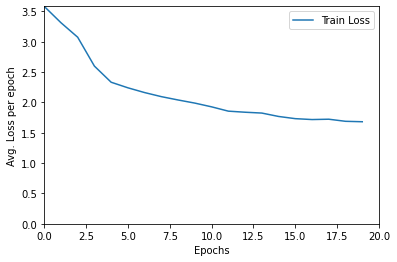

In [14]:
import matplotlib.pyplot as plt
def show_loss_graph(title, losses):
    plt.plot(losses, label="Train Loss")
    plt.title(title)
    plt.ylabel("Avg. Loss per epoch")
    plt.xlabel("Epochs")
    plt.ylim([0, max(losses)])
    plt.xlim([0, len(losses)])
    plt.legend()
    plt.show()

show_loss_graph("", all_losses)

In [16]:
for i in range(15):
  start_strings = [" ", " Don", " él", "el", " yo ", " qu", " r", " la", " s", " »", " >>", " ¿"]
  start = random.randint(0,len(start_strings)-1)
  print(start_strings[start])
#   all_characters.index(string[c])
  print(evaluate(start_strings[start], 300), '\n')

 s
 se volente el estigar de las que nos encomosiguios palas por las engran de secuderos, que entre la han remegino de ese esto que los mujeros, suemo
que hacermo el grande los mundo de don Quijote y en sus ha a vuestra cuando en la cara muchado digo por escardedodas, lo que los megudose dinerandose esta 

el
ella, si estas veces o amentisos de tantos, que me ha#a yo ve cuento a sus mermerampos que no es maneros que evente ingimiento que me la venta, que como por estas pramos en la cuando en esto de casa delante de mis
encandases sotrandes y destados las manos en vuastras de camas, y que no Huere tan megur 

 
 al manera de
queria el moro, que no esto que rupies, yo se los hacer que la verdad, sino que, divelew !:lguro de
inmestros meder de la encantara, aminados de imagino que el ques, como se quien >un esto, sino quien la cual respondio todo encorrinado, que no que tudo que no esta son de de menos que no 

 ¿
 ¿amaron que no esto acasar de magre, desperarde de la ella pago mas verced

---

## Part 6: Generate output on a different dataset

---

**TODO:**

**DONE:**

* Choose a textual dataset. Here are some [text datasets](https://www.kaggle.com/datasets?tags=14104-text+data%2C13205-text+mining) from Kaggle 

* Generate some decent looking results and evaluate your model's performance (say what it did well / not so well)


Answer:

The model was able to quickly put together that the sequence "qu" usually is followed by an "e" or "é". But the model struggles with figuring out how to use characters with tildes on them. I think my model just wasn't big enough for how many possible characters there were, I had to add a lot of new characters to the list of available characters.
